In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
# from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn
from cuml.svm import SVC
import cupy
from cuml.manifold import TSNE

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name,sample_weights=None):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train,sample_weight=sample_weights)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
sample_weights=None
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

## TSNE

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [11:08:24.784073] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
<class 'numpy.ndarray'>


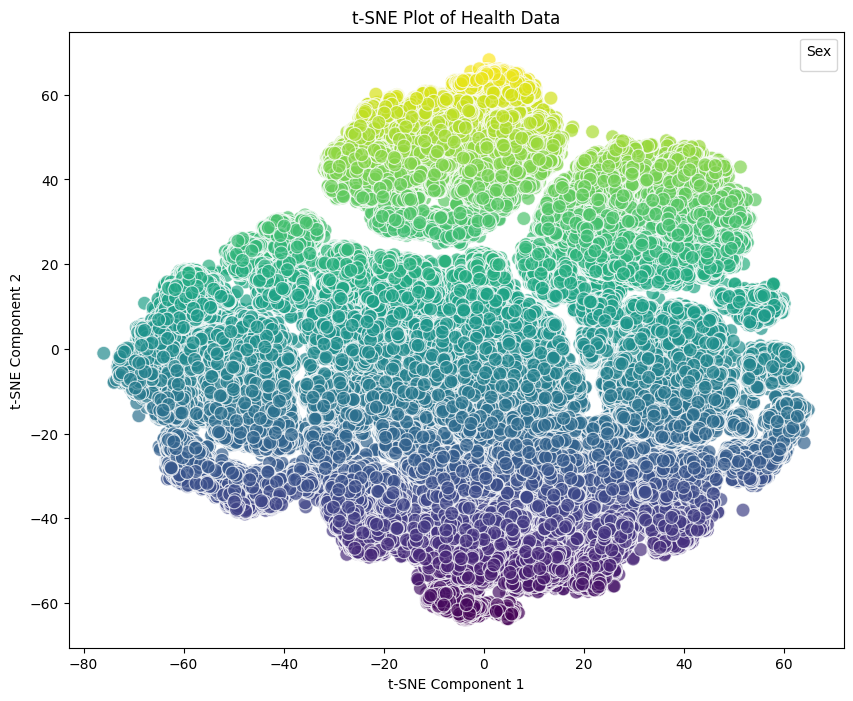

In [11]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_train).to_numpy()
print(type(tsne_results))
df=pd.DataFrame()
df['TSNE1'] = tsne_results[:, 0]
df['TSNE2'] = tsne_results[:, 1]
y=tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', data=df, c=y, s=100, alpha=0.7)
plt.title('t-SNE Plot of Health Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Sex')
plt.show()


## PCA

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


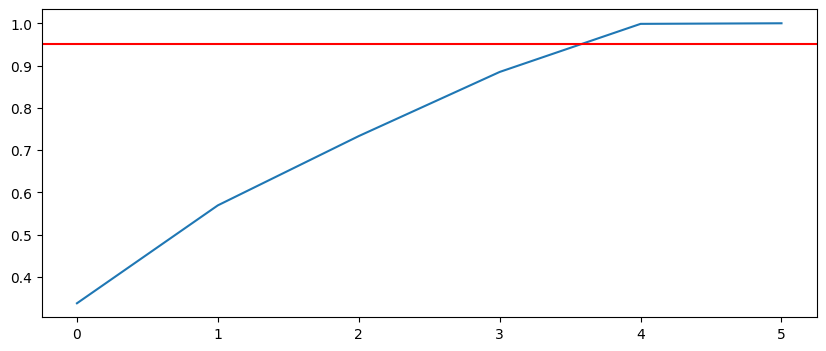

In [12]:
categorical_columns=categorical_features.copy()
categorical_columns.pop(categorical_columns.index('GeneralHealth'))


pca = PCA()
x_pca_2 = pca.fit(X_train[numerical_columns])
values = pca.explained_variance_ratio_

plt.figure(figsize = (10, 4))
ax = plt.subplot(111)

cumulative = np.cumsum(values)
ax.plot(cumulative)
plt.axhline(y=0.95, color='r', linestyle='-')
#print intersection point oh the red line with the curve

pca=PCA(n_components=4)
x_pca = pca.fit_transform(X_train[numerical_columns])

In [13]:
# x_pca=pca.transform(X_train[numerical_columns])
# x_pca = pd.DataFrame(x_pca)
# x_pca = pd.concat([x_pca,X_train[categorical_columns]],axis=1)
# X_train=x_pca.to_numpy()

# x_pca=pca.transform(X_test[numerical_columns])
# x_pca = pd.DataFrame(x_pca)
# x_pca = pd.concat([x_pca,X_test[categorical_columns]],axis=1)
# X_test=x_pca.to_numpy()
# X_train.shape, X_test.shape

## JL

In [14]:
def create_matrix_feature(d,n):
    matrix = np.random.normal(loc=0, scale=1.0/np.sqrt(n), size=(d, n))
    return matrix
output_dim=20
matrix_1=create_matrix_feature(X_train.shape[1],20)

In [15]:
# X_train=X_train.dot(matrix_1)
# X_test=X_test.dot(matrix_1)

## Undersampling

In [16]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state= 42)
# X_train , Y_train = rus.fit_resample(X_train, Y_train)
# X_train.shape,Y_train.shape

## coresets

In [17]:
from sklearn.utils.class_weight import compute_sample_weight
def compute_coreset(X, y, sample_size):
    # Compute sample weights (importance scores) based on class imbalance
    weights = compute_sample_weight(class_weight="balanced", y=y)
    probabilities = weights / np.sum(weights)
    indices = np.random.choice(len(X), size=sample_size, replace=False, p=probabilities)
    coreset_X = X[indices]
    coreset_y = y[indices]
    coreset_weights = weights[indices]
    
    return coreset_X, coreset_y, coreset_weights
X_train,Y_train,sample_weights=compute_coreset(X_train.to_numpy(),Y_train.to_numpy(),200000)
X_train.shape,Y_train.shape

((200000, 39), (200000,))

### Naive Bayes ###

**Default**

In [18]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'priors': None, 'var_smoothing': 1e-09}
GaussianNB()
Naive_Bayes training
Accuracy: 0.3186423005931833
Macro f1: 0.33614486675226474
Confusion Matrix:
 [[ 9282   386   937    58   728]
 [ 1209  3395  2064  2050   854]
 [ 9390  3983  4996   859  3327]
 [   67   861   237  1951    52]
 [16057  1702  3307   230  2991]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.81      0.39     11391
           1       0.33      0.35      0.34      9572
           2       0.43      0.22      0.29     22555
           3       0.38      0.62      0.47      3168
           4       0.38      0.12      0.19     24287

    accuracy                           0.32     70973
   macro avg       0.35      0.43      0.34     70973
weighted avg       0.37      0.32      0.29     70973



### Logistic Regression ###

**Default**

In [19]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': True, 'warm_start': False}
LogisticRegression(verbose=True)
Logistic_Regression training
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21888D+05    |proj g|=  7.64336D+05


 This problem is unconstrained.



At iterate   50    f=  2.46794D+05    |proj g|=  1.43861D+04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



At iterate  100    f=  2.42861D+05    |proj g|=  8.96339D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  200    100    111      1     0     0   8.963D+03   2.429D+05
  F =   242860.85491837416     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.44447888633705773
Macro f1: 0.4309452260740068
Confusion Matrix:
 [[ 4557   159  1481    47  5147]
 [  340  3724  3608   913   987]
 [ 2599  2493  9367   299  7797]
 [   22  1542   293  1251    60]
 [ 5010   710  5825    95 12647]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.40     

In [20]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Logistic Regression) --------------------
{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(random_state=42), 'n_jobs': -1, 'param_grid': {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': [

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
INFO:sklearnex: skle

Accuracy: 0.4555676102179702
Macro f1: 0.44711217937569536
Confusion Matrix:
 [[ 4198   173  1607    19  5394]
 [  231  3757  3809   787   988]
 [ 2036  2448  9878   181  8012]
 [   15  1426   305  1363    59]
 [ 4467   706  5926    51 13137]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.37      0.38     11391
           1       0.44      0.39      0.42      9572
           2       0.46      0.44      0.45     22555
           3       0.57      0.43      0.49      3168
           4       0.48      0.54      0.51     24287

    accuracy                           0.46     70973
   macro avg       0.47      0.43      0.45     70973
weighted avg       0.46      0.46      0.45     70973



### Random Forest ###

**Default**

In [21]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest",sample_weights)
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': True, 'warm_start': False}
RandomForestClassifier(n_jobs=-1, verbose=True)
Random_Forest training


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_fi

Accuracy: 0.4421540585856593
Macro f1: 0.43383073227703395
Confusion Matrix:
 [[ 4208   226  2020    16  4921]
 [  197  4295  3478   752   850]
 [ 1963  3254 10237   194  6907]
 [    7  1630   293  1193    45]
 [ 4627  1019  7135    58 11448]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.37      0.38     11391
           1       0.41      0.45      0.43      9572
           2       0.44      0.45      0.45     22555
           3       0.54      0.38      0.44      3168
           4       0.47      0.47      0.47     24287

    accuracy                           0.44     70973
   macro avg       0.45      0.42      0.43     70973
weighted avg       0.44      0.44      0.44     70973



In [22]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest",sample_weights)
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Random Forest) --------------------
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
Grid

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated 

Accuracy: 0.42213236019331296
Macro f1: 0.43691947944711196
Confusion Matrix:
 [[6301  382 1625   37 3046]
 [ 365 4798 2507 1251  651]
 [3567 4676 8696  364 5252]
 [  18 1295  164 1660   31]
 [7703 1684 6287  108 8505]]
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.55      0.43     11391
           1       0.37      0.50      0.43      9572
           2       0.45      0.39      0.42     22555
           3       0.49      0.52      0.50      3168
           4       0.49      0.35      0.41     24287

    accuracy                           0.42     70973
   macro avg       0.43      0.46      0.44     70973
weighted avg       0.44      0.42      0.42     70973



### Decision Tree ###

**Default**

In [23]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree",sample_weights)
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
DecisionTreeClassifier()
Decision_Tree training


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.34744198498020373
Macro f1: 0.3361211830645254
Confusion Matrix:
 [[3874  727 2524   85 4181]
 [ 653 3197 2916 1278 1528]
 [3507 4129 7640  813 6466]
 [  92 1218  524 1129  205]
 [5921 2372 6836  339 8819]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.34      0.30     11391
           1       0.27      0.33      0.30      9572
           2       0.37      0.34      0.36     22555
           3       0.31      0.36      0.33      3168
           4       0.42      0.36      0.39     24287

    accuracy                           0.35     70973
   macro avg       0.33      0.35      0.34     70973
weighted avg       0.36      0.35      0.35     70973



In [24]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree",sample_weights)
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET --------------------
{'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_sampl

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.32255928310766063
Macro f1: 0.3310625156289563
Confusion Matrix:
 [[ 8842   768   957   127   697]
 [ 1002  4295  1181  2843   251]
 [ 7760  6530  5126  1419  1720]
 [   56   715    86  2296    15]
 [13979  3263  4192   519  2334]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.78      0.41     11391
           1       0.28      0.45      0.34      9572
           2       0.44      0.23      0.30     22555
           3       0.32      0.72      0.44      3168
           4       0.47      0.10      0.16     24287

    accuracy                           0.32     70973
   macro avg       0.36      0.45      0.33     70973
weighted avg       0.40      0.32      0.28     70973



### SVM ###

**Default**

In [25]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

{'handle': <pylibraft.common.handle.Handle object at 0x78ed386e7300>, 'verbose': 5, 'output_type': 'input', 'C': 1, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': None, 'class_weight': None, 'multiclass_strategy': 'ovo'}
SVC()
SVM training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


[D] [11:16:45.401225] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:16:48.087333] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 106 outer iterations, total inner 24287 iterations, and diff 0.000991
[D] [11:16:48.235761] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:16:53.663929] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.h:281 Solver is not converging monotonically. This might be caused by insufficient normalization of the feature columns. In that case MinMaxScaler((0,1)) could help. Alternatively, for nonlinear kernels, you can try to increase the gamma parameter. To limit execution time, you can also adjust the number of iterations using the max_iter parameter.
[D] [11:16:55.244200] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 252 outer iterations, total inner 53088 iterations, and diff 0.000922

### Ada Boost ###


**Default**

In [26]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost",sample_weights)
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
AdaBoostClassifier()
ADA_Boost training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.34169331999492764
Macro f1: 0.3539605701465566
Confusion Matrix:
 [[ 8698   551   891   141  1110]
 [ 1061  4078  1079  3136   218]
 [ 7613  6024  5077  1477  2364]
 [   61   496    64  2539     8]
 [13324  2481  4105   518  3859]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.76      0.41     11391
           1       0.30      0.43      0.35      9572
           2       0.45      0.23      0.30     22555
           3       0.33      0.80      0.46      3168
           4       0.51      0.16      0.24     24287

    accuracy                           0.34     70973
   macro avg       0.37      0.48      0.35     70973
weighted avg       0.42      0.34      0.31     70973



In [27]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost",sample_weights)
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (AdaBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': 42, 'estimator': AdaBoostClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100]},
             scoring='f1_macro', verbose=4)
ADA_Boost training
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.3505981147760416
Macro f1: 0.36621094523135544
Confusion Matrix:
 [[ 8549   561   823   123  1335]
 [ 1035  4408  1067  2829   233]
 [ 7362  6302  4914  1228  2749]
 [   63   594    61  2441     9]
 [12772  2590  3947   407  4571]]
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.75      0.42     11391
           1       0.30      0.46      0.37      9572
           2       0.45      0.22      0.29     22555
           3       0.35      0.77      0.48      3168
           4       0.51      0.19      0.28     24287

    accuracy                           0.35     70973
   macro avg       0.38      0.48      0.37     70973
weighted avg       0.42      0.35      0.33     70973



### XG Boost ###

**Default**

In [28]:
model_xg = model_classifier(cupy.array(X_train),cupy.array(X_test),Y_train,Y_test,XGBClassifier(device='cuda'),"XG_Boost",sample_weights)
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None,

In [29]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(cupy.array(X_train), cupy.array(X_test), Y_train, Y_test, xgb_grid, "XG_Boost",sample_weights)
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


-------------------- METRICS ON DATASET (XGBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__device': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__feature_types': None, 'estimator__gamma': None, 'estimator__grow_policy': None, 'estimator__importance_type': None, 'estimator__interaction_constraints': None, 'estimator__learning_rate': None, 'estimator__max_bin': None, 'estimator__max_cat_threshold': None, 'estimator__max_cat_to_onehot': None, 'estimator__max_delta_step': None, 'estimator__max_depth': None, 'estimator__max_leaves': None, 'estimator__min_child_weight': None, 'estimator__missing': nan, 'estimator__monotone_constraints': None, 'es

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:22:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:22:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:


[CV 1/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.432 total time=  26.3s
[CV 3/3] END C=0.01, penalty=l2, solver=liblinear;, score=0.421 total time=  10.7s
[CV 3/3] END ...C=0.01, penalty=l2, solver=saga;, score=0.447 total time=  27.7s
[CV 3/3] END ....C=0.1, penalty=l2, solver=saga;, score=0.449 total time=  26.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  20.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  18.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  19.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  38.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  37.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_spli

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  36.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  36.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   8.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  17.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  17.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   8.7s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.9s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:22:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:22:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Accuracy: 0.34775196201372355
Macro f1: 0.36439318435764145
Confusion Matrix:
 [[ 8911   709   752   124   895]
 [  831  5015   911  2528   287]
 [ 7012  7270  4565  1072  2636]
 [   42   676    53  2380    17]
 [13389  3178  3525   385  3810]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.78      0.43     11391
           1       0.30      0.52      0.38      9572
           2       0.47      0.20      0.28     22555
           3       0.37      0.75      0.49      3168
           4       0.50      0.16      0.24     24287

    accuracy                           0.35     70973
   macro avg       0.38      0.48      0.36     70973
weighted avg       0.42      0.35      0.31     70973



In [30]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

,times,accuracies,macro_f1s,macro_f1s_train,accuracies_train
Naive_Bayes,0.124115,0.318642,0.336145,0.357200,0.353645
Logistic_Regression,120.575568,0.455568,0.447112,0.449361,0.445460
Random_Forest,293.374386,0.422132,0.436919,0.951329,0.951705
Decision_Tree,15.636208,0.322559,0.331063,0.383647,0.381810
SVM,49.390893,0.455737,0.368899,0.362099,0.422945
ADA_Boost,111.661761,0.350598,0.366211,0.395730,0.389960
XG_Boost,198.639795,0.347752,0.364393,0.434067,0.423410


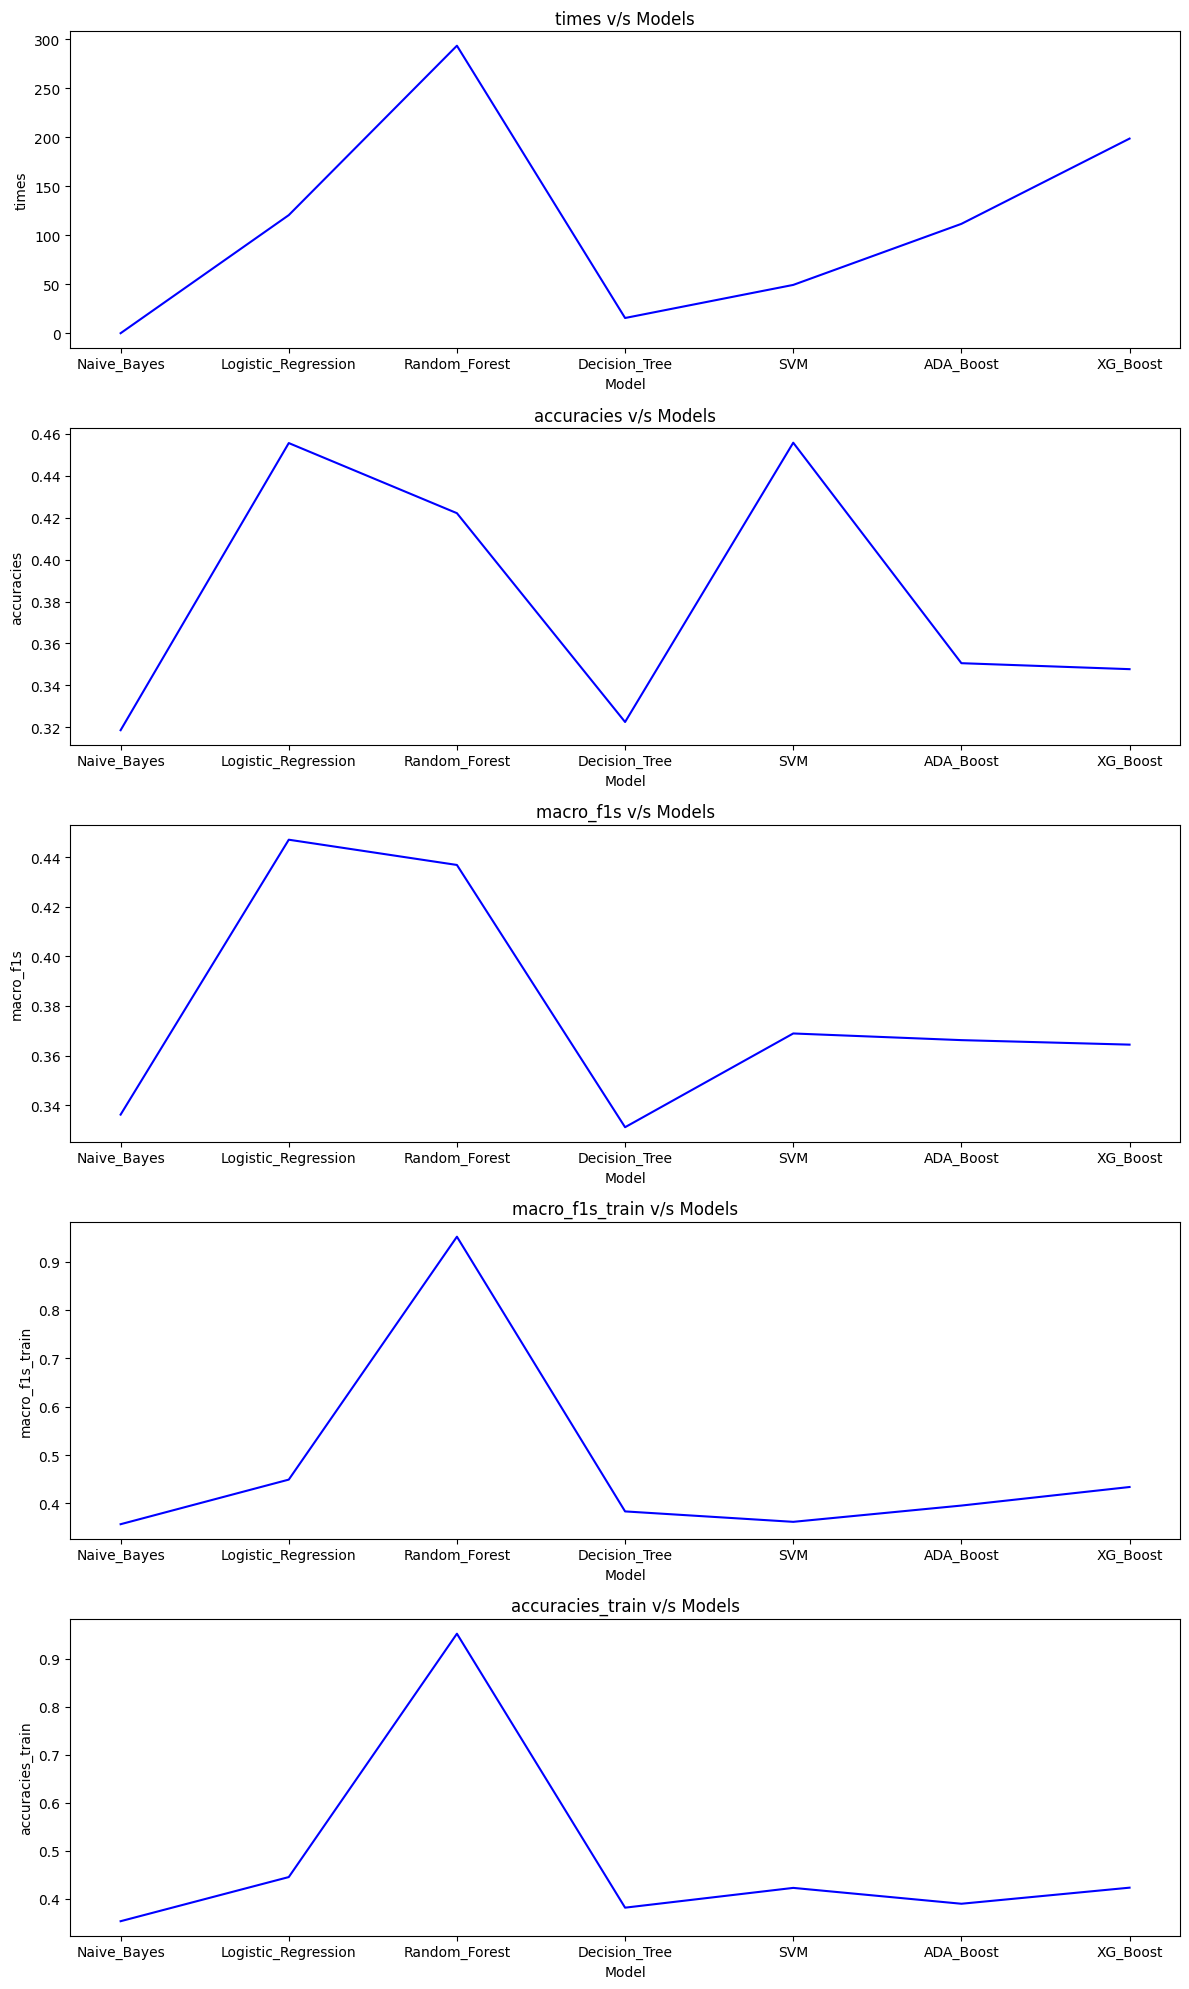

In [31]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()